# Prediction Intervals for Taxi Fares using Quantile Loss

TODO: intro...

[heteroskedastic](https://en.wikipedia.org/wiki/Heteroscedasticity)

## Setup

Below we'll be predicting taxi fares from pickup and dropoff location and times using [catboost](https://catboost.ai/), an implementation of gradient boosted decision trees.  Catboost can be installed via pip:

In [0]:
!pip install -q tf-nightly
!pip install -q tfp-nightly
!pip install -q catboost
!pip install -q --pre vaex

Then we can load the packages we'll use.

In [0]:
# Packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import vaex
from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict
from catboost import CatBoostRegressor
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Settings
sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(111)
tf.set_random_seed(111)

## Data

We'll be predicting taxi fares given pickup/dropoff locations and ride times, using the [New York City Taxi Fare dataset](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data).  First we'll load the information from the dataset concerning fares, times, and pickup/dropoff locations.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
%%time

# Columns to load
dtypes = {'fare_amount':      'float32',
          'pickup_datetime':  'str', 
          'pickup_longitude': 'float32',
          'pickup_latitude':  'float32',
          'dropoff_longitude':'float32',
          'dropoff_latitude': 'float32'}

# Load data
#train = pd.read_csv('train.csv', 
train = pd.read_csv('/content/gdrive/My Drive/DataScience/Data/train.zip', 
                    usecols=dtypes.keys(), dtype=dtypes,
                    nrows=1000000)

# Convert pickup time column to datetime
train['pickup_datetime'] = train['pickup_datetime'].str.slice(0, 16)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], 
                                          utc=True, format='%Y-%m-%d %H:%M')

CPU times: user 3.73 s, sys: 497 ms, total: 4.23 s
Wall time: 7.2 s


Now we can take a peek at the dataset we loaded.

In [5]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561
3,7.7,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764


How many null values there are in each column?

In [0]:
print('Column\tPercent Null')
for col in train:
    print(col, 100*train[col].isnull().sum()/train.shape[0])

Column	Percent Null
fare_amount 0.0
pickup_datetime 0.0
pickup_longitude 0.0
pickup_latitude 0.0
dropoff_longitude 0.001
dropoff_latitude 0.001


There are some null values, but a negligible amount of them, so we'll simply remove rows with null values.

In [0]:
train.dropna(inplace=True)

Instead of using the raw time, let's extract useful features from the time like the time of day, day of the week, day of the year, and the year.

In [0]:
# Extract useful time information
train['min_of_day'] = (60*train['pickup_datetime'].dt.hour + 
                       train['pickup_datetime'].dt.minute).astype('int32')
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek.astype('int32')
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear.astype('int32')
train['year'] = train['pickup_datetime'].dt.year.astype('int32')

# Remove original datetime column
train.drop('pickup_datetime', axis=1, inplace=True)

Let's check the fare amount distributions:

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


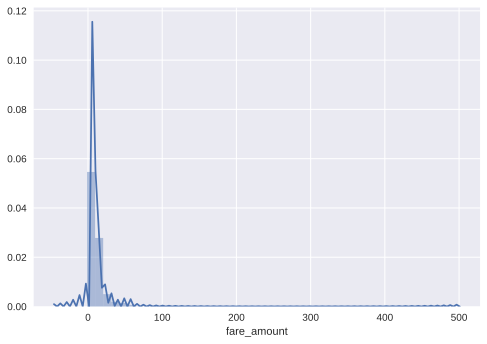

In [8]:
# Plot distribution of fares
sns.distplot(train['fare_amount'])
plt.show()

It looks like there might be some oddly large values, along with negative values (which doesn't make any sense, of course! Hopefully NYC taxi drivers aren't so desperate for business that they pay people to take trips with them...) . Let's zoom in on the area around 0.

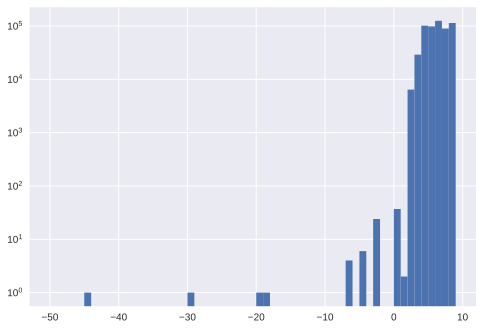

In [9]:
# Plot distribution of fares around 0
plt.hist(train['fare_amount'], 
         bins=np.arange(-50, 10), log=True)
plt.show()

Let's remove the datapoints with fares which are suspiciously low, and also rides with suspiciously high fares.

In [0]:
# Function to remove rows outside range
def clip(df, a, b, col):
    for c in col:
        df = df[(df[c]>a) & (df[c]<b)]
    return df

# Remove rows with outlier fare values
train = clip(train, 1, 200, ['fare_amount'])

Finally, let's check the locations of the pickups and dropoffs.

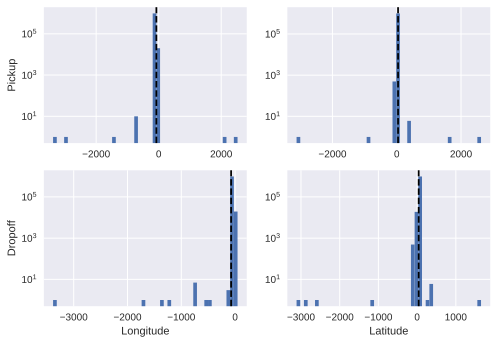

In [11]:
# Plot distribution of pickup longitudes
fig, ax = plt.subplots(2, 2)
nyc_lon = -74
nyc_lat = 40.7
ax[0,0].axvline(nyc_lon, linestyle='--', color='k')
ax[0,0].hist(train['pickup_longitude'], bins=50, log=True)
ax[0,0].set_ylabel('Pickup')
ax[1,0].axvline(nyc_lon, linestyle='--', color='k')
ax[1,0].hist(train['dropoff_longitude'], bins=50, log=True)
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('Dropoff')
ax[0,1].axvline(nyc_lat, linestyle='--', color='k')
ax[0,1].hist(train['pickup_latitude'], bins=50, log=True)
ax[1,1].axvline(nyc_lat, linestyle='--', color='k')
ax[1,1].hist(train['dropoff_latitude'], bins=50, log=True)
ax[1,1].set_xlabel('Latitude')
plt.show()

There are some pretty unreasonable outliers: longitudes can only lie between -180 and 180, and latitudes between -90 and 90.  Let's remove rows with geographical locations outside a reasonable range (near the greater NYC metropolitan area).

In [0]:
# Remove geographical outliers
train = clip(train,  -75, -72.5,
             ['pickup_longitude', 'dropoff_longitude'])
train = clip(train, 40, 41.5,
             ['pickup_latitude', 'dropoff_latitude'])

And now we have only values which are near NYC:

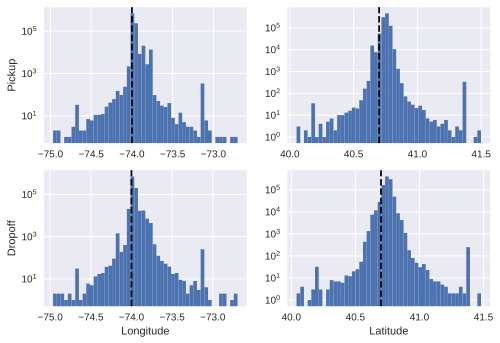

In [13]:
# Plot distribution of pickup longitudes
fig, ax = plt.subplots(2, 2)
nyc_lon = -74
nyc_lat = 40.7
ax[0,0].axvline(nyc_lon, linestyle='--', color='k')
ax[0,0].hist(train['pickup_longitude'], bins=50, log=True)
ax[0,0].set_ylabel('Pickup')
ax[1,0].axvline(nyc_lon, linestyle='--', color='k')
ax[1,0].hist(train['dropoff_longitude'], bins=50, log=True)
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('Dropoff')
ax[0,1].axvline(nyc_lat, linestyle='--', color='k')
ax[0,1].hist(train['pickup_latitude'], bins=50, log=True)
ax[1,1].axvline(nyc_lat, linestyle='--', color='k')
ax[1,1].hist(train['dropoff_latitude'], bins=50, log=True)
ax[1,1].set_xlabel('Latitude')
plt.show()

Let's plot the taxi pickup locations:

In [0]:
# Create vaex df from pandas df
vdf = vaex.from_pandas(train)

/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):


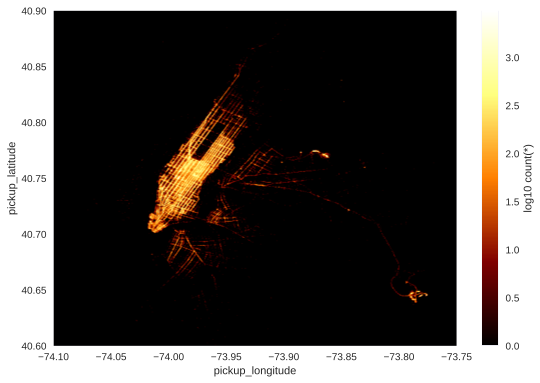

In [59]:
# Plot pickup locations as a heatmap
lims = [[-74.1, -73.75],[40.6, 40.9]]
cmap = matplotlib.cm.afmhot
cmap.set_bad('black', 1.)
vdf.plot('pickup_longitude', 'pickup_latitude', 
         limits=lims,
         f='log10', shape=500, 
         interpolation='spline16',
         background_color='black', background_alpha=0)

# Turn off grid
ax = plt.gca()
ax.grid(False)

And the dropoff locations (which looks pretty similar because the distribution of pickups and dropoff locations are similar)

/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):


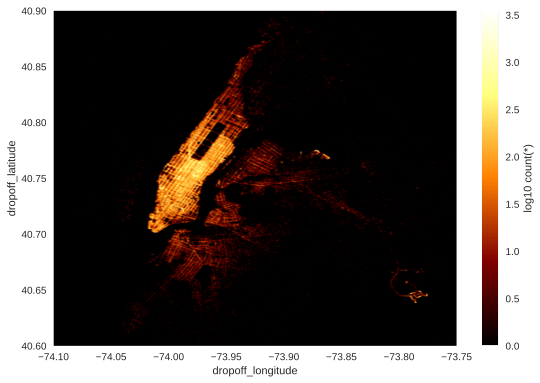

In [60]:
# Plot pickup locations as a heatmap
vdf.plot('dropoff_longitude', 'dropoff_latitude', 
         limits=lims,
         f='log10', shape=500, 
         interpolation='spline16',
         background_color='black', background_alpha=0)

# Turn off grid
ax = plt.gca()
ax.grid(False)

## Model

Let's use some simple models to try and predict the taxi fares from pickup/dropoff locations and times.  First we have to split the dataset into our features and target variables, and then we'll create a function which computes the mean absolute deviation between a given model's predictions and the true values.

In [0]:
# Separate in- from dependent variables
x_taxi = train.drop('fare_amount', axis=1)
y_taxi = train['fare_amount']

# Make Mean Absolute Error scorer
mae_scorer = make_scorer(mean_absolute_error)

# Function to print cross-validated mean abs deviation
def cv_mae(regressor, x, y, cv=3, scorer=mae_scorer):
    scores = cross_val_score(regressor, 
                             x, y, cv=cv,
                             scoring=scorer)
    print('MAE:', scores.mean())

How accurate can we be if we simply always predict the mean?  We'll use [Scikit-learn](https://scikit-learn.org)'s [`DummyRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html), which predicts the mean by default.

In [0]:
# MAE from predicting just the mean
cv_mae(DummyRegressor(), x_taxi, y_taxi)

MAE: 5.995057577581108


So, just by predicting the mean we can get within $6, on average.

What if we just use the distance of the trip as a predictor?  First we'll compute the euclidian distance between the pickup and dropoff location.  The distances are relatively small, since these are taxi trips within the NYC metropolitan area, so we won't worry about computing the [haversine distance](https://en.wikipedia.org/wiki/Haversine_formula) (which accounts for the curvature of the earth - if we were predicting say, airfares, we might want to use haversine distance).  Then we'll predict the fare based only on the distance using an [isotonic regression](https://en.wikipedia.org/wiki/Isotonic_regression), which assumes that the fare monotonically increases with distance.

In [0]:
# Distance between pickup and dropoff locations
dist = np.sqrt(
    np.power(train['pickup_longitude'] -
             train['dropoff_longitude'], 2) + 
    np.power(train['pickup_latitude'] - 
             train['dropoff_latitude'], 2))

# MAE from using just distance as predictor
cv_mae(IsotonicRegression(out_of_bounds='clip'), 
       dist, y_taxi)

MAE: 2.2998350973508748


This results in much better predictions than just guessing the mean.  Using only the distance, we can on average predict the taxi fare within $2.30.

Finally, we can get down to a mean absolute error of close to $2 if we use all the information available to us (pickup/dropoff locations and the time of pickup), with gradient boosted decision trees ([catboost](https://catboost.ai), specifically).

In [0]:
# Cross-validated MAE w/ CatBoost
cv_mae(CatBoostRegressor(logging_level='Silent'), 
       x_taxi, y_taxi)

MAE: 2.0682634529018107


## Heteroskedasticity

One thing we need to look out for when predicting uncertainty is [heteroskedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity)!  Heteroskedasticity is when the variance of the predicted variable (the dependent variable, in our case the taxi fare amounts) changes as a function of the features (the independent variables, in our case the pickup/dropoff locations and times).

However, simple models often can't capture variance in the dependent variable when it changes as a function of the independent variable.  For example, a simple linear model

$$
y = mx + b + \epsilon
$$

usually assumes that the noise term is normally distributed,

$$
\epsilon \sim \mathcal{N}(0, \sigma)
$$

But this assumes that the variance of the normally-distributed noise ($\sigma$) isn't changing as a function of $x$!  In a lot of real-world data, the variance of $y$ changes as a function of $x$.  Let's generate some heteroskedastic data just to see what that looks like.


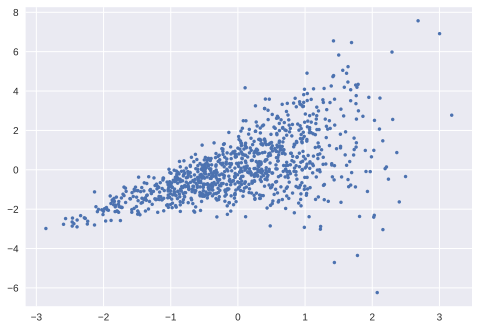

In [0]:
# A function to generate heteroskedastic data
def h_func(x):
    return x + np.exp(0.5*x)*np.random.randn(x.shape[0],1)

# Generate heteroskedastic data
N = 1000
x = np.atleast_2d(np.random.randn(N)).T
y = h_func(x).ravel()

# Generate validation data
x_val = np.atleast_2d(np.random.randn(N)).T
y_val = h_func(x_val).ravel()

# Plot data we generated
plt.plot(x, y, '.')
plt.show()

Is our taxi fares data heteroskedastic?

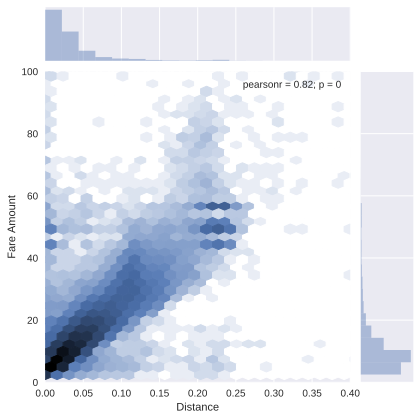

In [0]:
# Plot distance vs fare
sns.jointplot('Distance', 'Fare Amount',
              pd.DataFrame({'Distance':dist, 
                            'Fare Amount':y_taxi}), 
              kind="hex",
              xlim=(0, 0.4), ylim=(0, 100),
              joint_kws=dict(gridsize=70, bins='log'))

Indeed it looks like the true data is heteroskedastic - the variance of the fare amount appears to increase with the distance of the trip.  Also keep in mind that above we plotted the fare against only the *distance*, whereas the full dataset has pickup/dropoff location, time of day, time of year, etc.  The $y$-values could be heteroskedastic as a function of those predictors as well!




## Quantile Regression

What if we now want to predict our uncertainty as to our estimate, instead of only coming up with a single best estimate?  Predicting an estimate and the uncertainty as to that estimate seems especially challenging when that uncertainty varies with our independent variables.  A quantile regression is one method for estimating uncertainty which can be used with our model (gradient boosted decision trees).

With a quantile regression we can separately estimate the expected value, the upper bound of the (say, 95%) predictive interval, and the lower bound of the predictive interval.  That is, we're predicting not just the mean, but also the 97.5-th *quantile* of the data, and the 2.5-th quantile.

To do this we can just change the loss function we're using.  Instead of minimizing a defualt loss like the sum of squared error, we minimize the quantile loss for a choosen quantile value $q$.  The quantile loss for true values $y$, the predicted values $\hat{y}_i$, and a desired quantile $q$ (from 0 to 1) is

$$
L_q(y,\hat{y}) = (q-1) \sum_{i \in y_i<\hat{y}_i} |y_i-\hat{y}_i| + q \sum_{i \in y_i \geq \hat{y}_i} |y_i-\hat{y}_i|
$$

TODO: explain penalizes y_pred>y_true more than y_true>y_pred when quantile<0.5 and vice-versa.  diagrams, etc

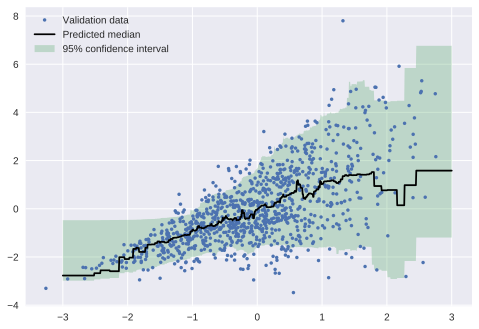

In [0]:
# Gradient boosted tree regressors w/ different quantile losses
gbrL = CatBoostRegressor(loss_function='Quantile:alpha=0.025', logging_level='Silent')
gbr = CatBoostRegressor(loss_function='Quantile:alpha=0.5', logging_level='Silent')
gbrH = CatBoostRegressor(loss_function='Quantile:alpha=0.975', logging_level='Silent')

# Using scikit-learn's gradient boosted decision trees
#from sklearn.ensemble import GradientBoostingRegressor
#gbrL = GradientBoostingRegressor(loss='quantile', alpha=0.025)
#gbr = GradientBoostingRegressor(loss='quantile', alpha=0.5)
#gbrH = GradientBoostingRegressor(loss='quantile', alpha=0.975)

# Fit to data
gbrL.fit(x, y)
gbr.fit(x, y)
gbrH.fit(x, y)

# Predict over x range
xx = np.atleast_2d(np.linspace(-3, 3, N)).T
y_predL = gbrL.predict(xx)
y_pred = gbr.predict(xx)
y_predH = gbrH.predict(xx)

# Plot predictions over points
plt.figure()
plt.plot(x_val, y_val, '.',
         label='Validation data')
plt.fill_between(xx.ravel(), y_predL, y_predH,
                 alpha=0.3, facecolor=colors[1],
                 label='95% confidence interval')
plt.plot(xx, y_pred, 'k', label='Predicted median')
plt.legend()
plt.show()

To see how well-calibrated the model is, we can check the coverage of the 95% confidence interval (the percentage of y values from the validation dataset falling within our 95% predictive interval).  If the model is well-calibrated, the coverage will be near 95%.

In [0]:
# Function to compute coverage of predictive interval
def coverage(y, yL, yH):
     return (100 / yL.shape[0] *
             ((y>yL)&(y<yH)).sum())
    
# Predict on validation samples
y_predL = gbrL.predict(x_val)
y_pred = gbr.predict(x_val)
y_predH = gbrH.predict(x_val)

# Compute coverage of the 95% interval
print('Coverage of 95%% predictive interval: %0.1f%%'
      % coverage(y_val, y_predL, y_predH))

Coverage of 95% predictive interval: 89.1%


Hmm. OK but not great.  How does it look on the real data?

In [0]:
# Compute 2.5% and 97.5% predictive intervals
y_predL = cross_val_predict(gbrL, x_taxi, y_taxi)
y_predH = cross_val_predict(gbrH, x_taxi, y_taxi)

# Compute coverage of the 95% interval
print('Coverage of 95%% predictive interval: %0.1f%%'
      % coverage(y_taxi, y_predL, y_predH))

Coverage of 95% predictive interval: 81.5%


Hmm, that's not so great at all!  We can manually calibrate our model by adjusting the theoretical desired quantile such that our predictions acctually fall within the 95% predictive interval

In [0]:
#TODO: manually find good prctiles which give coverage of 95% interval = 95%

However, if we plot the coverage of the 95% predictive interval as a function of the independent variables, we can see that our model isn't completely capturing the heteroskedasticity.  It's capturing *some* of the changes in variance as a function of the independent variables, but not all of it.  For example, if we look at the coverage of the 95% predictive interval as a function of pickup time we can (see / not see) that the coverage changes over time of day.

In [0]:
#TODO: plot coverage as a fn of time of day

Also, plotting the coverage of the predictive interval by pickup location, we can see that the coverage varies across pickup locations as well.

In [0]:
# TODO: use Vaex to visualize coverage of 95% interval as a fn of location (bins)
# https://github.com/vaexio/vaex

## Conclusion

TODO: quantile regressions are a great way to estimate uncertainty, but sometimes they need to be calibrated.  In the next post we'll make a bayesian nnet whicch estimates the predictions and the uncertaitnty separately.

## Dual-module Bayesian Neural Network



In [0]:
# Settings
batch_size = 512
max_steps = 2000
learning_rate = 0.005

In [0]:
# DEBUGGER: reset the graph so you can re-run
tf.reset_default_graph() 

In [0]:
def build_input_pipeline(x, y, x_val, y_val, batch_size, N_val):
  '''Build an Iterator switching between train and heldout data.
  Args:
    x: Numpy `array` of training features, indexed by the first dimension.
    y: Numpy `array` of training labels, with the same first dimension as `x`.
    x_val: Numpy `array` of validation features, indexed by the first dimension.
    y_val: Numpy `array` of validation labels, with the same first dimension as `x_val`.
    batch_size: Number of elements in each training batch.
    N_val: Number of examples in the validation dataset
  Returns:
    batch_features: `Tensor` feed  features, of shape
      `[batch_size] + x.shape[1:]`.
    batch_labels: `Tensor` feed of labels, of shape
      `[batch_size] + y.shape[1:]`.
  '''
  # Build an iterator over training batches.
  training_dataset = tf.data.Dataset.from_tensor_slices((x, y))
  training_batches = training_dataset.shuffle(
      50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
  train_iterator = training_batches.make_one_shot_iterator()

  # Build a iterator over the validation set with batch_size=N_val,
  # i.e., return the entire heldout set as a constant.
  val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  val_frozen = val_dataset.take(N_val).repeat().batch(N_val)
  val_iterator = val_frozen.make_one_shot_iterator()

  # Combine these into a feedable iterator that can switch between training
  # and validation inputs.
  handle = tf.placeholder(tf.string, shape=[])
  feedable_iterator = tf.data.Iterator.from_string_handle(
      handle, training_batches.output_types, training_batches.output_shapes)
  batch_features, batch_labels = feedable_iterator.get_next()

  return batch_features, batch_labels, handle, train_iterator, val_iterator

# Build input pipeline
x_vals, y_vals,  handle, training_iterator, validation_iterator = (
    build_input_pipeline(x, y, x_val, y_val, batch_size, N_val) )

In [0]:
# A dense network specified by a list of Nunits per layer
def DenseNetReg(layers, x_in)
  prior = tfp.layers.default_mean_field_normal_fn()
  for units in layers:
    layer = tfp.layers.DenseFlipout(
      units=units, 
      kernel_posterior_fn=prior,
      bias_posterior_fn=prior)
    x_in = layer(x_in)
  layer = tfp.layers.DenseFlipout( #final layer w/ no activation
      units=1, 
      activation=None,
      kernel_posterior_fn=prior,
      bias_posterior_fn=prior)
  return layer(x_in)

# A linear regression model: a Normal distribution
# parameterized by location from a dense multi-layer net,
# and std dev frmo a dense multi-layer net
with tf.name_scope("dual_module_regression", values=[x_vals]):
  predictions = DenseNetReg([32, 16, 8], x_vals)  
  noise_std = DenseNetReg([32, 16, 8], x_vals)  
  pred_distribution = tfd.Normal(loc=predictions, 
                                 scale=noise_std)

In [0]:
# Compute the -ELBO as the loss, averaged over the batch size
neg_log_likelihood = -tf.reduce_mean(pred_distribution.log_prob(y_vals))
kl_div = sum(layer.losses) / N #TODO: need to sum losses from all layers?
elbo_loss = neg_log_likelihood + kl_div

# Mean absolute error metric for evaluation
mse, mse_update_op = tf.metrics.mean_absolute_error(
    labels=y_vals, predictions=predictions)

# Use ADAM optimizer w/ -ELBO loss
with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(elbo_loss)

In [0]:
# To store parameter values over training
weight_mean = layer.kernel_posterior.mean()[:,0]
weight_std = layer.kernel_posterior.stddev()[:,0]
bias_mean = layer.bias_posterior.mean()
bias_std = layer.bias_posterior.stddev()
noise_std_mean = noise_std.mean()
noise_std_std = noise_std.stddev()
weight_means = np.zeros((max_steps, D))
weight_stds = np.zeros((max_steps, D))
bias_means = np.zeros(max_steps)
bias_stds = np.zeros(max_steps)
noise_stds = np.zeros(max_steps)
noise_means = np.zeros(max_steps)
mses = np.zeros(max_steps)
losses = np.zeros(max_steps)

# Initialization op
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# Run the training session
with tf.Session() as sess:
  sess.run(init_op)

  # Training loop
  train_handle = sess.run(training_iterator.string_handle())
  val_handle = sess.run(validation_iterator.string_handle())
  with Timer():
    for iS in range(max_steps):
      [
          _,
          _,
          mses[iS],
          losses[iS],
          weight_means[iS,:],
          weight_stds[iS,:],
          bias_means[iS],
          bias_stds[iS],
          noise_means[iS],
          noise_stds[iS]
      ] = sess.run([
          train_op,
          mse_update_op,
          mse,
          elbo_loss,
          weight_mean,
          weight_std,
          bias_mean,
          bias_std,
          noise_std_mean,
          noise_std_std
      ], feed_dict={handle: train_handle})

  # Draw samples from the posterior
  Nmc = 1000
  w_draw = layer.kernel_posterior.sample(Nmc)
  b_draw = layer.bias_posterior.sample(Nmc)
  n_draw = noise_std.sample(Nmc)
  w_post, b_post, n_post = sess.run([w_draw, b_draw, n_draw])
  
  # Draw predictive distribution samples
  prediction_dist_var = sess.run((pred_distribution.sample(Nmc)), 
                                 feed_dict={handle: val_handle})

In [0]:
# Compute proportion of estimates on validation data 
# which fall within the 95% prediction interval
q0 = 2.5
q1 = 97.5
within_conf_int = np.zeros(N_val)
for i in range(N_val):
  pred_dist = prediction_dist_var[:, i, 0]
  p0 = np.percentile(pred_dist, q0)
  p1 = np.percentile(pred_dist, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int[i] = 1

print('%0.1f %% of validation samples are w/i the %0.1f %% prediction interval' 
      % (100*np.mean(within_conf_int), q1-q0))